<a href="https://colab.research.google.com/github/edoofra/TwitterSentimentAnalysisBERT/blob/main/BERT_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The rise of social media has made it easier than ever for people to express their opinions on a wide range of topics. In this project, we will be using the BERT language model to perform sentiment analysis on tweets. BERT, which stands for "Bidirectional Encoder Representations from Transformers," is a state-of-the-art language model that can understand the context of words in a sentence, allowing it to accurately predict the sentiment of a given tweet. By using BERT, we will be able to analyze the sentiment of tweets and gain insight into how people feel about a particular topic on Twitter.

# **Twitter Sentiment Analysis**

*My ridiculous dog is amazing. [sentiment: positive]*

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

Help build your skills in this important area with this broad dataset of tweets. Work on your technique to grab a top spot in this competition. What words in tweets support a positive, negative, or neutral sentiment? How can you help make that determination using machine learning tools?


Useful link:


*   [Dataset](https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset)
*   [Competition](https://www.kaggle.com/competitions/tweet-sentiment-extraction/overview)



Import the dataset and install libraries

In [1]:
import torch

# if present, use the gpu as a device

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [2]:
%%capture

!pip install transformers
!wget https://raw.githubusercontent.com/serivan/DeepLearning/master/Datasets/Tweets.csv

# **Dataset preprocessing**

In [3]:
import pandas as pd

df = pd.read_csv('Tweets.csv')

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# drop delle colonne inutili per il task di classificazione
# sostituzione della label della classe con interi
df['labels'] = [2 if v == "positive" else 0 if v == "negative" else 1 for v in df.sentiment.tolist()]
df.drop(["textID", "selected_text", "sentiment"], axis=1, inplace=True)

df

,text,labels
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0
...,...,...
27476,wish we could come see u on Denver husband l...,0
27477,I`ve wondered about rake to. The client has ...,0
27478,Yay good for both of you. Enjoy the break - y...,2
27479,But it was worth it ****.,2


#Tokenizer and data processing

In [4]:
from transformers import BertTokenizer

# Load the BERT tokenizer
# uso un tokenizer già pre-addestrato
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
# Tokenization is the process of breaking down a text into smaller pieces called tokens. 
# In the case of BERT, which is a type of language model, the tokens are usually sub-words or words in the text. 
# BERT uses a technique called "WordPiece" tokenization, which breaks words down into smaller sub-words, called "WordPieces," 
# while trying to maintain the meaning of the original text as much as possible. 
# For example, the word "good" might be broken down into the WordPieces "good" and "##ness". 
# These WordPieces are then used as input to the BERT model.
def preprocessing_for_bert(data, max_len):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_sent = tokenizer(sent,
                                 padding='max_length',  
                                 truncation=True,       
                                 max_length=max_len) 
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
from sklearn.model_selection import train_test_split

X = df.text.tolist()
y = df.labels.tolist()

# Split the data in train, validation and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2023)

In [6]:
# Study the average length of a text record 
# perchè alcune frasi potrebbero superare la lunghezza massima di BERT in input
tot=0
for x in X:
  tot+=len(x.split())
print(tot/len(X))

12.90287481804949


In [7]:
#i tweet hanno un numero max di caratteri
# imposto quindi una lunghezza massima non troppo grande
max_len = 20

# Run function `preprocessing_for_bert` on the train set, the validation set and the test set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train, max_len)
val_inputs, val_masks = preprocessing_for_bert(X_val,  max_len)
test_inputs, test_masks = preprocessing_for_bert(X_test, max_len)

Tokenizing data...


In [8]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, it's recommended a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

#Define the model

\#TODO Set the hyperparameters manually or using **grid search**

In [10]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        # dimensioni livello di classificazione
        # 768 input che corrisponde a output di BERT
        # 100 neuroni livello denso
        # 3 classi in output
        D_in, H, D_out = 768, 200, 3 

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate a feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H,200),
            nn.ReLU(),
            nn.Linear(200,H),
            nn.ReLU(),
            nn.Dropout(0.3), 
            nn.Linear(H, D_out))

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        pass
        
    def forward(self, input_ids, attention_mask):

        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits


        pass

In [11]:
import random
import time
import numpy as np
from tqdm import tqdm

#Training procedure

# Specify loss function
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

#Used in train
def evaluate(model, val_dataloader):
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False, accumulation=16):
    print("Start training...\n")

    #list to be returned
    train_losses=[]
    train_accs=[]
    val_losses=[]
    val_accs=[]

    #For the first step of evaluation
    eval_loss=10000
    best_model=None

    for epoch_i in range(epochs):
        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        acc = 0
        total = 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(tqdm(train_dataloader)):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)


            with torch.cuda.amp.autocast():
                  #Set the previous grad to 0 
                  model.zero_grad()
                  # Perform a forward pass. This will return logits.
                  logits = model(b_input_ids, b_attn_mask)
                  # Compute loss and accumulate the loss values
                  loss = loss_fn(logits, b_labels)
                  loss /= accumulation

            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            scaler.scale(loss).backward()

            # Accumulation step. It's fondamental when you try to train BERT on Colab GPUs, it avoids the error CUDA_OUT_OF_MEMORY 
            if (step + 1) % accumulation == 0 or step+1 == len(train_dataloader):
              scaler.step(optimizer)
              scaler.update()


        # Print training results
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}")
        print("-"*70)

        # Reset batch tracking variables
        batch_loss, batch_counts = 0, 0

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        predictions = torch.max(logits, 1).indices.to(device)

        acc += (predictions.detach().cpu().numpy() == b_labels.detach().cpu().numpy()).sum()
        total += len(b_labels)

        epoch_acc = acc*100/total
        train_accs.append(epoch_acc)
        print("-"*70)


        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.

            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_losses.append(val_loss)
            val_accs.append(val_accuracy)
            if val_loss <= eval_loss:
              eval_loss = val_loss
              best_model = model

            # Print performance over the entire training data            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f}")
            print("-"*70)
        print("\n")

    
    print("Training complete!")
    return train_losses, train_accs, val_losses, val_accs, best_model


In [14]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model():
    bert_classifier = BertClassifier()
    bert_classifier.to(device)

    # Choose an optimizer
    optimizer = torch.optim.AdamW(bert_classifier.parameters(), 
                      lr=3e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      ) 

    return bert_classifier, optimizer

In [16]:
set_seed(42)

epochs = 8
accumulation = 16
evaluation = True

bert_classifier, optimizer = initialize_model()
train_losses, train_accs, val_losses, val_accs, best_model = train(bert_classifier, train_dataloader, val_dataloader, epochs, evaluation, accumulation)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...



100%|██████████| 1392/1392 [01:01<00:00, 22.75it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   1    |    -    |   0.065456   |  0.916112  |   67.90  
----------------------------------------------------------------------




100%|██████████| 1392/1392 [00:58<00:00, 23.94it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   2    |    -    |   0.051957   |  0.775614  |   68.96  
----------------------------------------------------------------------




100%|██████████| 1392/1392 [00:57<00:00, 24.04it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   3    |    -    |   0.046402   |  0.716201  |   71.27  
----------------------------------------------------------------------




100%|██████████| 1392/1392 [00:58<00:00, 23.98it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   4    |    -    |   0.043748   |  0.706236  |   71.52  
----------------------------------------------------------------------




100%|██████████| 1392/1392 [00:57<00:00, 24.07it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   5    |    -    |   0.042566   |  0.685965  |   71.58  
----------------------------------------------------------------------




100%|██████████| 1392/1392 [00:59<00:00, 23.36it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   6    |    -    |   0.040888   |  0.704055  |   71.61  
----------------------------------------------------------------------




100%|██████████| 1392/1392 [00:58<00:00, 23.99it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   7    |    -    |   0.040278   |  0.712010  |   71.54  
----------------------------------------------------------------------




100%|██████████| 1392/1392 [00:58<00:00, 23.97it/s]


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
----------------------------------------------------------------------
----------------------------------------------------------------------
   8    |    -    |   0.040228   |  0.679963  |   72.30  
----------------------------------------------------------------------


Training complete!


#Test your model

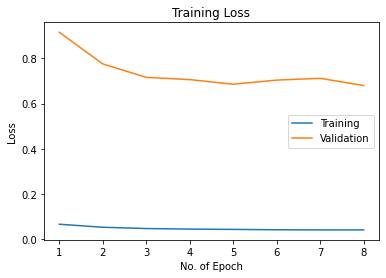

In [17]:
import matplotlib.pyplot as plt


plt.plot(range(1, epochs+1), train_losses, label="Training")
plt.plot(range(1, epochs+1), val_losses, label="Validation")
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(loc="center right")
plt.show()

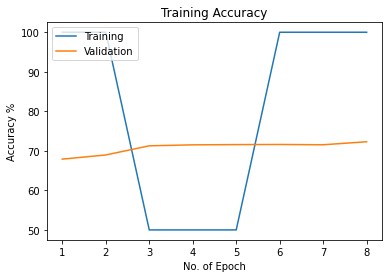

In [18]:
plt.plot(range(1, epochs+1), train_accs, label="Training")
plt.plot(range(1, epochs+1), val_accs, label="Validation")
plt.xlabel("No. of Epoch")
plt.ylabel("Accuracy %")
plt.title("Training Accuracy")
plt.legend(loc="upper left")
plt.show()

In [19]:
def predict(model, val_dataloader):
    model.eval()
    predictions=[]
   
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        preds = torch.argmax(logits, dim=1).flatten()
        predictions.append(int(preds.detach().cpu().numpy()))

    return predictions

In [20]:
from sklearn.metrics import classification_report

predictions = predict(bert_classifier, test_dataloader)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       746
           1       0.71      0.69      0.70      1143
           2       0.79      0.77      0.78       859

    accuracy                           0.73      2748
   macro avg       0.73      0.73      0.73      2748
weighted avg       0.73      0.73      0.73      2748



In [21]:
best_model.to(device)
predictions = predict(best_model, test_dataloader)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       746
           1       0.71      0.69      0.70      1143
           2       0.79      0.77      0.78       859

    accuracy                           0.73      2748
   macro avg       0.73      0.73      0.73      2748
weighted avg       0.73      0.73      0.73      2748

